**Keywords**: Principal Component Analysis (PCA), Eigenvalues and Eigenvectors

**About the dataset**: \
[*Labeled Faces in the Wild*](http://vis-www.cs.umass.edu/lfw/) dataset consists of face photographs designed for studying the problem of unconstrained face recognition. The original dataset contains more than 13,000 images of faces collected from the web.

**Agenda**:
* In this notebook, I will be performing face recognition on the *Labeled Faces in the Wild* dataset using PyTorch. 
* First, I will perform Principal Component Analysis (PCA) on the image dataset. PCA is used for dimentionality reduction which is a type of unsupervised learning.
* PCA is being applied on the dataset to extract the principal components (Top $k$ *eigenvalues*). 
* The reconstruction of faces from these *eigenvalues* will give us the *eigen-faces* which are the most representative features of most of the images in the dataset. 
* Finally, we will train a simple PyTorch Neural Network model on the modified image dataset.
* This trained model will be used for prediction and evaluation on a test set.



---



### Data Loading

Loading the dataset directly from the scikit-learn library

In [1]:
import numpy as np
from sklearn.datasets import fetch_lfw_people
dataset = fetch_lfw_people(min_faces_per_person=80)

Each 2D image is of size 62 x 47 pixels, represented by a 2D array. The value of each pixel is a real value from 0 to 255.

In [2]:
count, height, width = dataset.images.shape
print('The dataset type is:',type(dataset.images))
print('The number of images in the dataset:',count)
print('The height of each image:',height)
print('The width of each image:',width)

The dataset type is: <class 'numpy.ndarray'>
The number of images in the dataset: 1140
The height of each image: 62
The width of each image: 47


Sklearn also gives us a flattened version of the images which is a vector of size 62 x 47 = 2914.

In [3]:
print('The shape of data is:',dataset.data.shape)

The shape of data is: (1140, 2914)


For optimum performance, we have only considered people who have more than 80 images. This restriction notably reduces the size of the dataset.\
Now let us look at the labels of the people present in the dataset

In [4]:
targets = [(x,y) for x,y in zip(range(len(np.unique(dataset.target))), dataset.target_names)]
print('The target labels and names are:\n', targets)

The target labels and names are:
 [(0, 'Colin Powell'), (1, 'Donald Rumsfeld'), (2, 'George W Bush'), (3, 'Gerhard Schroeder'), (4, 'Tony Blair')]




---



### Preprocessing

Using the `train_test_split` API from sklearn, splitting the data into train and test dataset in the ratio 3:1. Using `random_state=42`. 

In [5]:
X = dataset.data 
y = dataset.target

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y ,
                                   random_state=42, 
                                   test_size=0.25)

In [7]:
X_train[0:5,0:5]

array([[ 48.333332,  49.666668,  57.      ,  78.333336,  93.666664],
       [201.66667 , 193.33333 , 165.33333 , 140.33333 , 130.66667 ],
       [ 43.666668,  47.      ,  52.      ,  69.666664, 170.      ],
       [ 95.      ,  93.      ,  77.      ,  60.      ,  74.      ],
       [ 92.      ,  92.333336,  96.333336,  99.666664, 115.666664]],
      dtype=float32)

For better performance, normalizing the features which can have different ranges with huge values. Using the `StandardScaler` class from sklearn and using that to normalize X_train and X_test.

In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled[0:5,0:5]

array([[-0.9654278 , -1.0295011 , -1.0190297 , -0.72766125, -0.602009  ],
       [ 2.5243912 ,  2.3122559 ,  1.5580599 ,  0.7567845 ,  0.28822863],
       [-1.0716397 , -1.0915291 , -1.1379724 , -0.93516463,  1.234607  ],
       [ 0.09669096, -0.02154656, -0.5432593 , -1.1666105 , -1.0751982 ],
       [ 0.0284119 , -0.03705349, -0.08334787, -0.2168843 , -0.07267863]],
      dtype=float32)



---



### Dimentionality reduction

Using the `PCA` API from sklearn to extract the top 100 principal components of the image matrix and fit it on the training dataset.

In [10]:
from sklearn.decomposition import PCA

n_component=100

pca=PCA(n_component,svd_solver="randomized",whiten=True)
pca.fit(X_train_scaled)

PCA(n_components=100, svd_solver='randomized', whiten=True)

Now we will plot the most representative eigenfaces: 

In [11]:
# Helper function to plot
import matplotlib.pyplot as plt
def plot_gallery(images, titles, height, width, n_row=2, n_col=4):
    plt.figure(figsize=(2* n_col, 3 * n_row))
    plt.subplots_adjust(bottom=0, left=0.01, right=0.99, top=0.90, hspace=0.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((height, width)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

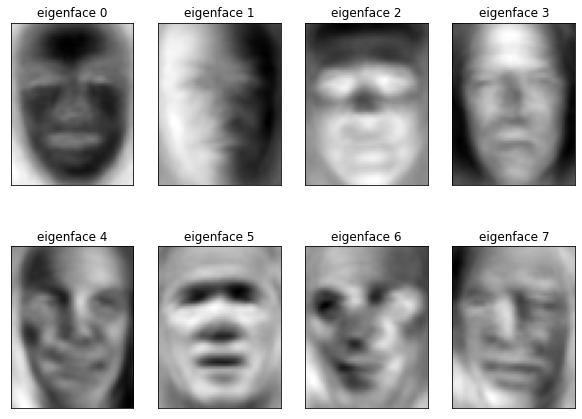

In [12]:
# getting the 100 eigen faces and reshaping them to original image size which is 62 x 47 pixels 
eigenfaces = pca.components_.reshape((n_component, height, width))

# plotting the top 8 eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, height, width)

plt.show()



---



### Face reconstruction

Reconstructing an image from its point projected on the principal component basis.

In [13]:
image_to_recon = X_train_scaled[0:3]
images_to_print = []

images_to_print.append(image_to_recon)

for n_component in [10,100,150,500]:
    pca_t=PCA(n_component,svd_solver="randomized",whiten=True)
    pca_t.fit(X_train_scaled)
    recon_image = pca_t.inverse_transform(pca_t.transform(image_to_recon))
    images_to_print.append(recon_image)

Projecting the first three faces on the eigenvector basis using PCA models trained with varying number of principal components.

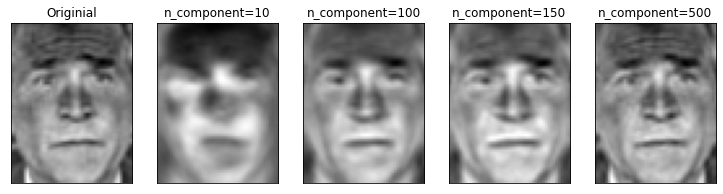

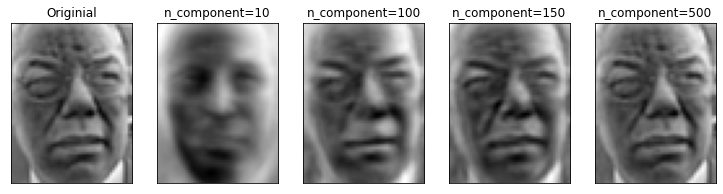

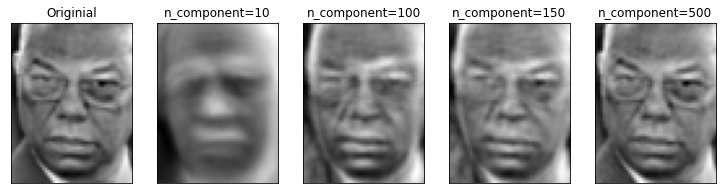

In [14]:
images_to_print=np.transpose(np.array(images_to_print),axes=(1,0,2))
labels = ["Originial","n_component=10","n_component=100","n_component=150","n_component=500"]

for i in range(len(images_to_print)):
    plot_gallery(images_to_print[i], labels, height, width,n_row=1, n_col=5)



---



### Prediction

In [15]:
import torch
import torch.nn as nn

Before we start training, we need to transform the training and test dataset to reduced forms (100 dimensions) using the pca function defined above. We will also need to move the train and test dataset to torch tensors in order to work with pytorch.

In [16]:
# Projecting X_train and X_test on orthonormal basis using the PCA API initialized in part (b). 
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)


# Now converting X_train_pca, X_test_pca, y_train and y_test to torch.tensor. For y_train and y_test, setting dtype=torch.long
X_train_pca_torch = torch.Tensor(X_train_pca)
X_test_pca_torch = torch.Tensor(X_test_pca)
y_train_torch = torch.Tensor(y_train).type(torch.long)
y_test_torch = torch.Tensor(y_test).type(torch.long)


In [17]:
# Implementing a simple multilayer perceptron (MLP) in pytorch with one hidden layer. 
# Using this neural network model, we will train on the transformed dataset.
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()

        self.fc1 = torch.nn.Linear(100, 1024)
        self.fc2 = torch.nn.Linear(1024, 5)
        self.relu = torch.nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        linear1 = self.fc1(x)
        relu = self.relu(linear1)
        linear2 = self.fc2(relu)
        output = self.logsoftmax(linear2)
        return output

In [18]:
# Creating an instance of the MLP class here
model = MLP()

# Defining loss 
criterion = torch.nn.NLLLoss()

# Defining optimizer 
lr = 1e-1
optimizer = torch.optim.SGD(model.parameters(),lr=lr)

# Training the classifier on the PCA-transformed training data for 500 epochs
for epoch in range(501):
    optimizer.zero_grad()

    output=model(X_train_pca_torch)

    loss=criterion(output, y_train_torch)

    loss.backward()

    optimizer.step()

    if epoch%50==0:
        print('Epoch: {}, Loss: {:.3f}'.format(epoch, loss.item()))

Epoch: 0, Loss: 1.707
Epoch: 50, Loss: 0.426
Epoch: 100, Loss: 0.213
Epoch: 150, Loss: 0.128
Epoch: 200, Loss: 0.085
Epoch: 250, Loss: 0.061
Epoch: 300, Loss: 0.046
Epoch: 350, Loss: 0.037
Epoch: 400, Loss: 0.030
Epoch: 450, Loss: 0.025
Epoch: 500, Loss: 0.021


In [19]:
# Predicting on test data
predictions = model(X_test_pca_torch) # gives softmax logits
y_pred = torch.argmax(predictions, dim=1).numpy() # getting the labels from prdictions: nx5 -> nx1

### Multi-label classification report: precision, recall, f1-score

                   precision    recall  f1-score   support

     Colin Powell       0.92      0.89      0.90        64
  Donald Rumsfeld       0.89      0.78      0.83        32
    George W Bush       0.90      0.95      0.93       127
Gerhard Schroeder       0.92      0.83      0.87        29
       Tony Blair       0.83      0.88      0.85        33

         accuracy                           0.90       285
        macro avg       0.89      0.87      0.88       285
     weighted avg       0.90      0.90      0.90       285



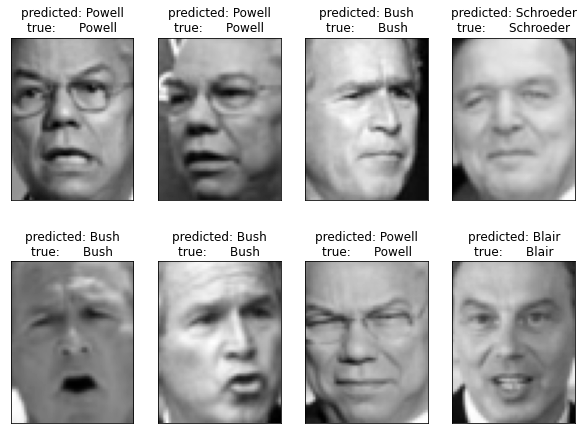

In [20]:
from sklearn.metrics import classification_report
target_names=[y for x,y in targets]
print(classification_report(y_test, y_pred, target_names=target_names))

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(" ", 1)[-1]
    true_name = target_names[y_test[i]].rsplit(" ", 1)[-1]
    return "predicted: %s\ntrue:      %s" % (pred_name, true_name)

prediction_titles = [
    title(y_pred, y_test, target_names, i) for i in range(y_pred.shape[0])
]

plot_gallery(X_test, prediction_titles, height, width)



---

